C:\Users\han\AppData\Local\Temp\ipykernel_16840\3469554633.py:115: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_esd = df.groupby("name", group_keys=False).apply(detect_sh_esd)


✔ Saved: data\volatility_jumps_pos_sh_esd_plus.csv, data\volatility_full_pos_sh_esd_plus.csv


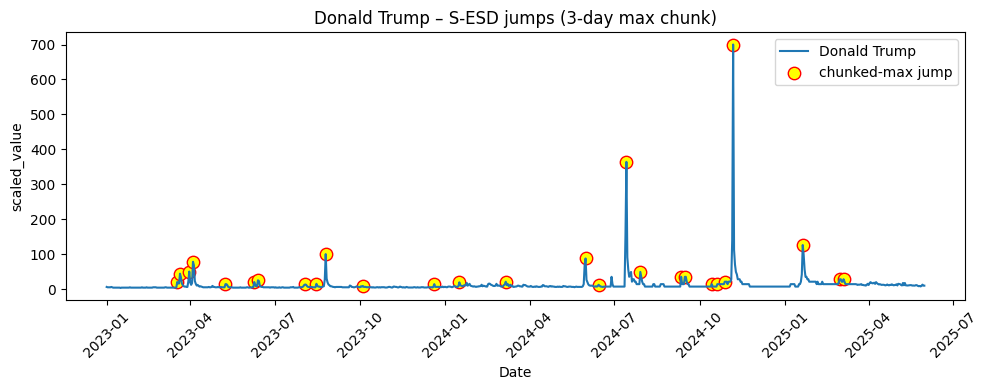

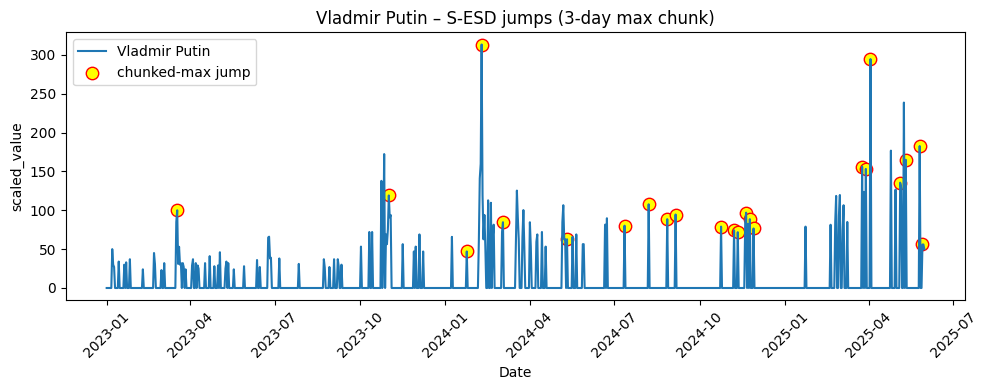

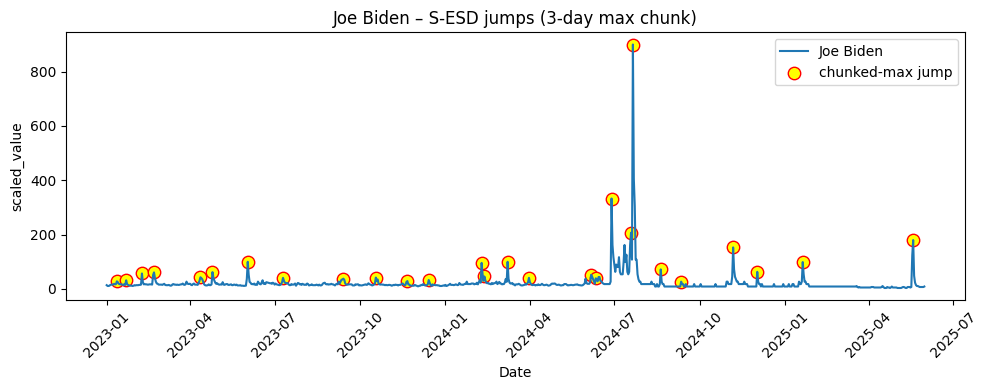

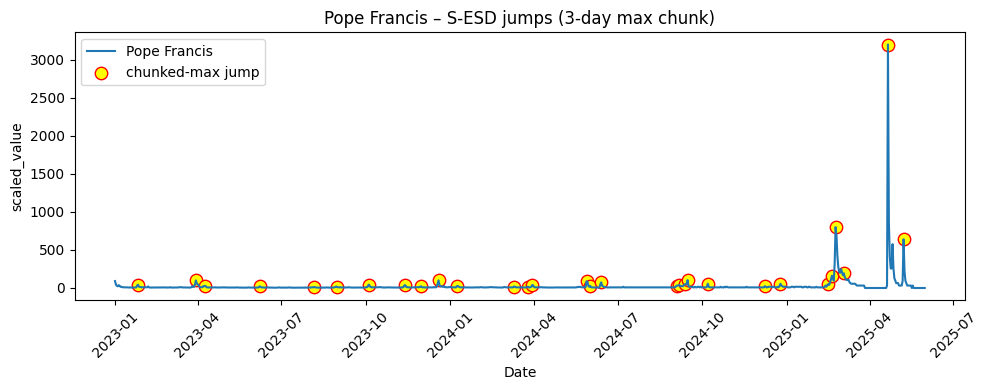

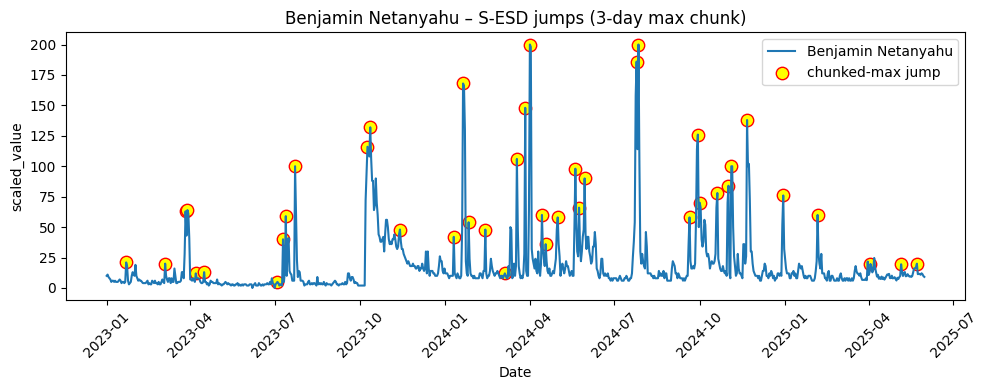

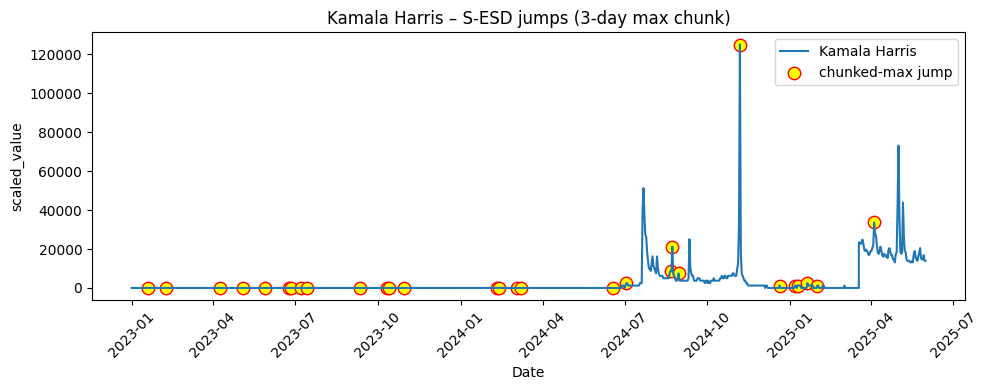

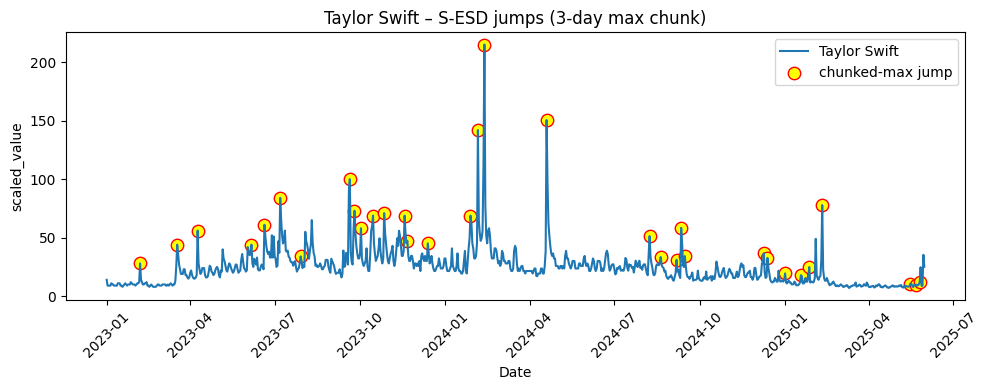

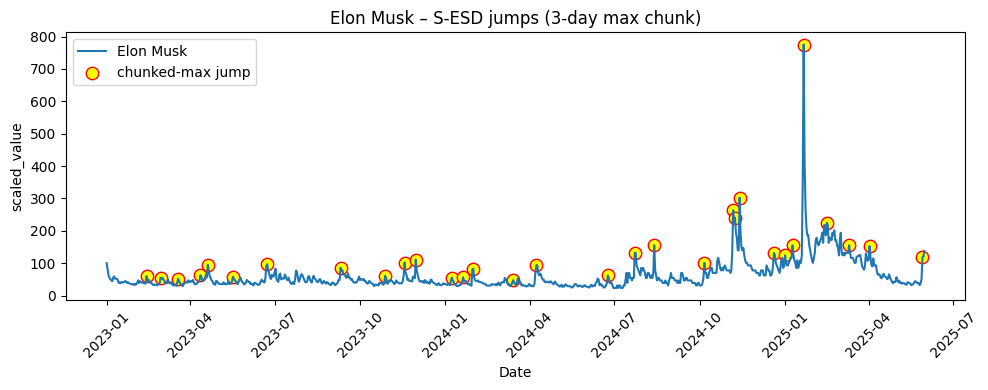

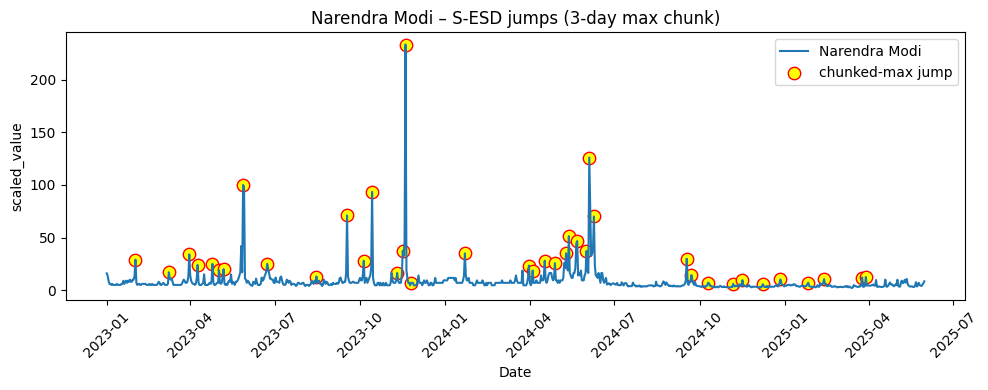

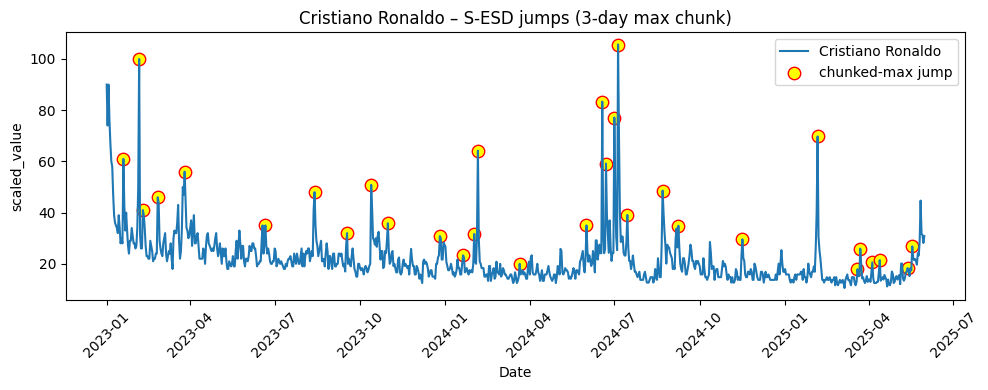

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
detect_and_plot_volatility_sh_esd_chunked_max.py
────────────────────────────────────────────────────────────
Seasonal-Hybrid ESD 이후,
연속 감지된 jump는 3일 블록으로 묶어 그 블록 내
scaled_value가 최대인 날만 라벨링
"""
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from scipy import stats

DATA_DIR        = Path("data")
SRC_TRENDS      = DATA_DIR / "scaled_trends_merged_bridge.csv"
# OUT_JUMPS       = DATA_DIR / "volatility_jumps_pos_sh_esd_chunked_max.csv"
# OUT_FULL        = DATA_DIR / "volatility_full_pos_sh_esd_chunked_max.csv"
OUT_JUMPS       = DATA_DIR / "volatility_jumps_pos_sh_esd_plus.csv"
OUT_FULL        = DATA_DIR / "volatility_full_pos_sh_esd_plus.csv"
FINAL_CSV       = Path("final.csv")

STL_PERIOD      = 7
ALPHA_GLOBAL    = 0.01
MAX_GLOBAL      = 0.10
ALPHA_LOCAL     = 0.01
MAX_LOCAL       = 0.10
DELTA_THRESHOLD = 0

def generalized_esd(x, alpha, max_anoms):
    n = len(x)
    r = int(np.floor(max_anoms * n))
    if r < 1:
        return []
    anomalies = []
    data = x.copy()
    for i in range(1, r+1):
        μ, sig = data.mean(), data.std(ddof=1)
        if sig == 0 or np.isnan(sig):
            break
        diffs = (data - μ).abs()
        j = diffs.idxmax()
        R = diffs[j] / sig
        p = alpha / (n - i + 1)
        t = stats.t.ppf(1 - p/2, df=n - i - 1)
        ld = t * (n - i - 1) / np.sqrt((n - i - 1 + t**2)*(n - i))
        if R > ld:
            anomalies.append(j)
            data = data.drop(j)
        else:
            break
    return anomalies

def detect_sh_esd(group):
    g = group.copy().reset_index(drop=True)
    # 1) STL residual
    stl = STL(g["scaled_value"], period=STL_PERIOD, robust=True).fit()
    resid = pd.Series(stl.resid, index=g.index)

    # 2) global ESD
    glob_idx  = generalized_esd(resid, ALPHA_GLOBAL, MAX_GLOBAL)
    glob_mask = resid.index.isin(glob_idx)

    # 3) local ESD by quarter
    g["quarter"] = g["date"].dt.to_period("Q")
    local_mask = pd.Series(False, index=g.index)
    for _, qgrp in g.groupby("quarter"):
        idxs = qgrp.index
        locs = generalized_esd(resid.loc[idxs], ALPHA_LOCAL, MAX_LOCAL)
        local_mask.loc[locs] = True

    # 4) delta filter
    g["delta"] = g["scaled_value"].diff().fillna(0)

    # 5) initial vol_jump mask
    mask = (glob_mask | local_mask) & (g["delta"] > DELTA_THRESHOLD)

    # 6) 3일 블록 단위로, 블록 내 최대 scaled_value 날만 선별
    sel = mask.copy()           # 결과용
    vals = g["scaled_value"].values
    N    = len(mask)
    i    = 0
    while i < N:
        if mask.iat[i]:
            # 블록 범위: [i, i+1, i+2]
            end = min(i + 3, N)
            block = list(range(i, end))
            # 블록 내 값들
            block_vals = vals[block]
            # 가장 큰 날의 상대 인덱스
            rel = int(np.argmax(block_vals))
            keep = block[rel]
            # 블록 전체를 False, keep 만 True
            for j in block:
                sel.iat[j] = False
            sel.iat[keep] = True
            i += 3
        else:
            i += 1

    g["vol_jump"] = sel
    g["label"]    = sel.map({True: "up"}).fillna("")
    g.drop(columns=["quarter"], inplace=True)
    return g

def main():
    # 1) load & preprocess
    df = pd.read_csv(SRC_TRENDS, parse_dates=["date"])
    df["date"] = df["date"].dt.tz_localize(None)
    df.sort_values(["name","date"], inplace=True)

    # 2) apply S-H-ESD + chunked max logic per name
    df_esd = df.groupby("name", group_keys=False).apply(detect_sh_esd)

    # 3) save
    DATA_DIR.mkdir(parents=True, exist_ok=True)
    df_esd[df_esd["vol_jump"]].to_csv(OUT_JUMPS, index=False)
    df_esd.to_csv(OUT_FULL, index=False)
    print(f"✔ Saved: {OUT_JUMPS}, {OUT_FULL}")

    # 4) plot top10 from final.csv
    final_df = pd.read_csv(FINAL_CSV)
    final_df["total"] = final_df[["count_2023","count_2024","count_2025"]].sum(axis=1)
    top10 = final_df.nlargest(10, "total")["name"].tolist()

    for name in top10:
        sub = df_esd[df_esd["name"]==name].sort_values("date")
        if sub.empty:
            print(f"[경고] '{name}' 데이터 없음.")
            continue

        fig, ax = plt.subplots(figsize=(10,4))
        ax.plot(sub["date"], sub["scaled_value"], label=name)
        jumps = sub[sub["vol_jump"]]
        ax.scatter(jumps["date"], jumps["scaled_value"],
                   s=80, facecolors="yellow", edgecolors="red",
                   label="chunked-max jump")
        ax.set_title(f"{name} – S-ESD jumps (3-day max chunk)")
        ax.set_xlabel("Date"); ax.set_ylabel("scaled_value")
        ax.legend(); plt.xticks(rotation=45); plt.tight_layout(); plt.show()

if __name__ == "__main__":
    main()


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
merge_jump_dates.py
────────────────────────────────────────────────────────────
· volatility_jumps_pos.csv → 인물별 jump 날짜(YYYYMMDD) 리스트 생성
· final.csv 과 머지 후 jump 없는 인물 행 제거
· 결과: final_with_jump_dates.csv
"""

from pathlib import Path
import pandas as pd

# ───────────────────────── 파일 경로
JUMP_CSV  = Path("data/volatility_full_pos_sh_esd_plus.csv")
FINAL_CSV = Path("final.csv")
OUT_CSV   = Path("final_with_jump_dates_s_esd_plus.csv")

# ───────────────────────── 1) 점프 날짜 집계
jumps = (
    pd.read_csv(JUMP_CSV, parse_dates=["date"])
      .loc[lambda df: df["vol_jump"]]           # 혹시 모를 False 제외
)

# 날짜를 YYYYMMDD 정수로 변환
jumps["date_int"] = jumps["date"].dt.strftime("%Y%m%d").astype(int)

# 인물별 날짜 리스트
jump_dates = (
    jumps.groupby("name")["date_int"]
         .apply(lambda x: sorted(x.unique().tolist()))   # 중복 제거·정렬
         .reset_index(name="vol_jump_dates")
)

# ───────────────────────── 2) final.csv 과 머지
final_df = pd.read_csv(FINAL_CSV)

merged = (
    final_df.merge(jump_dates, on="name", how="inner")   # jump 없는 인물 제거
          .sort_values("name")
          .reset_index(drop=True)
)

# ───────────────────────── 3) 저장
merged.to_csv(OUT_CSV, index=False)
print(f"✔ 저장 완료: {OUT_CSV} ({len(merged)} rows)")

✔ 저장 완료: final_with_jump_dates_sh_esd_plus.csv (208 rows)
